In [1]:
import pandas as pd
import numpy as np
import os

print(os.getcwd())

# Load the new cleaned multi-ticker dataset
csv_path = os.path.join("..", "data", "processed", "multi_ticker_options_clean.csv")
df = pd.read_csv(csv_path)

# Check columns
print(df.columns)

C:\Users\msuma\Desktop\options-trading-bot\notebooks
Index(['contractSymbol', 'lastTradeDate', 'strike', 'lastPrice', 'bid', 'ask',
       'change', 'percentChange', 'volume', 'openInterest',
       'impliedVolatility', 'inTheMoney', 'contractSize', 'currency', 'ticker',
       'expiry', 'days_to_expiry', 'spot_price', 'moneyness',
       'date_collected'],
      dtype='object')


In [2]:
# Sort by ticker and date
df = df.sort_values(by=["ticker", "date_collected"])

# Shift lastPrice by -1 to get the next day's price within each ticker
df["future_price"] = df.groupby("ticker")["lastPrice"].shift(-1)

# Create binary target
df["target"] = (df["future_price"] > df["lastPrice"]).astype(int)

# Drop rows where future_price or target couldn't be created
df = df.dropna(subset=["future_price", "target"])

# Preview
print(df[["lastPrice", "future_price", "target"]].head(10))


     lastPrice  future_price  target
478      91.49         61.36       0
479      61.36         53.74       0
480      53.74         52.13       0
481      52.13         43.55       0
482      43.55         41.38       0
483      41.38         37.16       0
484      37.16         30.10       0
485      30.10         30.59       1
486      30.59         26.25       0
487      26.25         24.12       0


In [3]:
# Drop non-numeric columns
df_numeric = df.select_dtypes(include=["number"])

# Drop leakage and testing-dependency columns
X = df_numeric.drop(columns=["target", "future_price", "return_1d"], errors="ignore")
y = df["target"]

print("Features used in model (without return_1d):")
print(X.columns.tolist())


Features used in model (without return_1d):
['strike', 'lastPrice', 'bid', 'ask', 'change', 'percentChange', 'volume', 'openInterest', 'impliedVolatility', 'days_to_expiry', 'spot_price', 'moneyness']


Accuracy: 0.8310991957104558

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       308
           1       0.53      0.28      0.36        65

    accuracy                           0.83       373
   macro avg       0.70      0.61      0.63       373
weighted avg       0.80      0.83      0.81       373



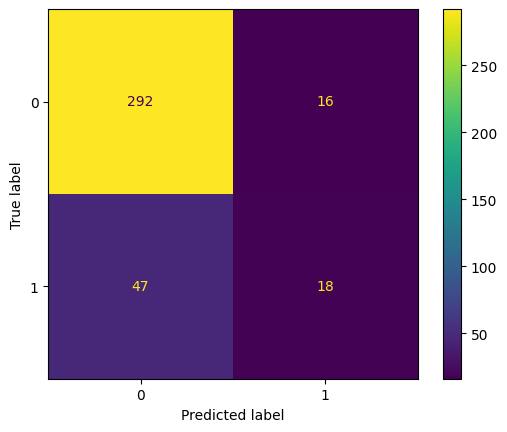

In [4]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import xgboost as xgb

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost
model = xgb.XGBClassifier(eval_metric='logloss')
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Show confusion matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)


C:\Users\msuma\Desktop\options-trading-bot\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


🔹 Logistic Regression Accuracy: 0.8284182305630027

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.97      0.90       308
           1       0.53      0.15      0.24        65

    accuracy                           0.83       373
   macro avg       0.69      0.56      0.57       373
weighted avg       0.79      0.83      0.79       373

🔹 ROC-AUC Score: 0.7714285714285714


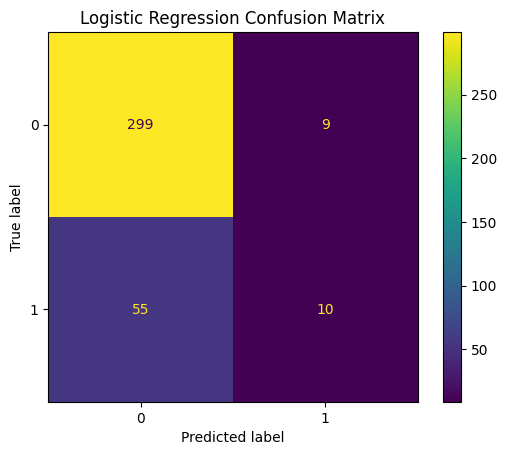

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, ConfusionMatrixDisplay

# Train Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Predict
y_pred_log = log_reg.predict(X_test)
y_proba_log = log_reg.predict_proba(X_test)[:, 1]

# Evaluate
print("🔹 Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print("\n🔹 Classification Report:\n", classification_report(y_test, y_pred_log))
print("🔹 ROC-AUC Score:", roc_auc_score(y_test, y_proba_log))

# Show Confusion Matrix
ConfusionMatrixDisplay.from_estimator(log_reg, X_test, y_test)
plt.title("Logistic Regression Confusion Matrix")
plt.show()


In [6]:
from sklearn.metrics import roc_auc_score

y_proba = model.predict_proba(X_test)[:, 1]
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))


ROC-AUC Score: 0.7993256743256743


<Figure size 1000x600 with 0 Axes>

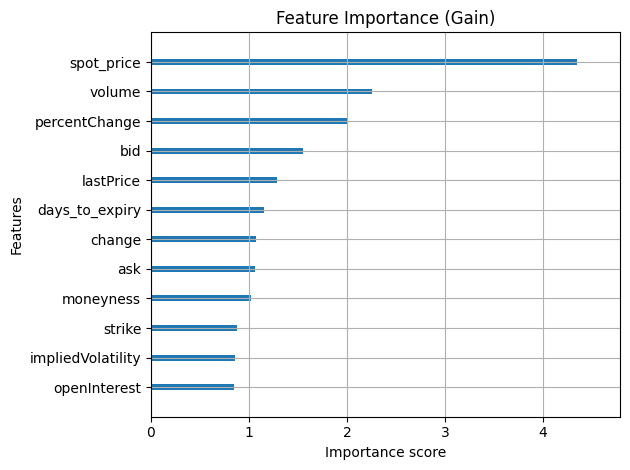

In [7]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plt.figure(figsize=(10, 6))
plot_importance(model, importance_type="gain", show_values=False)
plt.title("Feature Importance (Gain)")
plt.tight_layout()
plt.savefig("../images/feature_importance.png")
plt.show()


In [8]:
from sklearn.model_selection import train_test_split

# Split your full dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("✅ Data split complete.")
print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)


✅ Data split complete.
Training set size: (1491, 12)
Testing set size: (373, 12)


In [9]:
!pip install imbalanced-learn


In [10]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Initialize the scaler
scaler = StandardScaler()

# Fit only on training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE on the scaled training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Sanity check
print("✅ Scaling and SMOTE complete.")
print("Before SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE:", pd.Series(y_train_resampled).value_counts().to_dict())


✅ Scaling and SMOTE complete.
Before SMOTE: {0: 1227, 1: 264}
After SMOTE: {0: 1227, 1: 1227}


In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define search space
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Initialize classifier with class_weight for imbalance
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Randomized search
random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=20,
    scoring='roc_auc',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit search on resampled + scaled data
random_search.fit(X_train_resampled, y_train_resampled)


# Best model
best_rf = random_search.best_estimator_

print("✅ Best Parameters Found:")
print(random_search.best_params_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
✅ Best Parameters Found:
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20}


🔹 Accuracy: 0.806970509383378

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.87      0.88       307
           1       0.46      0.53      0.49        66

    accuracy                           0.81       373
   macro avg       0.68      0.70      0.69       373
weighted avg       0.82      0.81      0.81       373

🔹 ROC-AUC Score: 0.8079903267199685


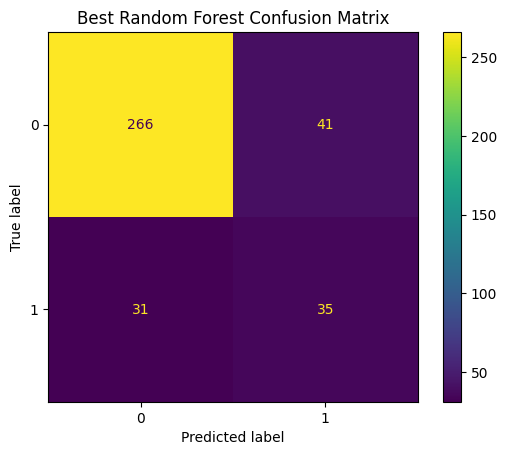

In [12]:
# Predict using the best Random Forest model
y_pred_best = best_rf.predict(X_test_scaled)
y_proba_best = best_rf.predict_proba(X_test_scaled)[:, 1]

# Print key metrics
print("🔹 Accuracy:", accuracy_score(y_test, y_pred_best))
print("\n🔹 Classification Report:\n", classification_report(y_test, y_pred_best))
print("🔹 ROC-AUC Score:", roc_auc_score(y_test, y_proba_best))

# Display confusion matrix
ConfusionMatrixDisplay.from_estimator(best_rf, X_test_scaled, y_test)
plt.title("Best Random Forest Confusion Matrix")
plt.show()


In [13]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Get feature importances from trained RF
importances = best_rf.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Select top N features (e.g., top 10)
top_n = 10
top_features = importance_df['Feature'].iloc[:top_n].tolist()

# Filter train and test data
X_train_top = X_train_resampled[:, [X_train.columns.get_loc(f) for f in top_features]]
X_test_top = X_test_scaled[:, [X_train.columns.get_loc(f) for f in top_features]]

# Retrain RF on reduced feature set
rf_top = best_rf.__class__(**best_rf.get_params())
rf_top.fit(X_train_top, y_train_resampled)
rf_preds = rf_top.predict(X_test_top)

# Evaluate
rf_results = {
    "Accuracy": accuracy_score(y_test, rf_preds),
    "ROC AUC": roc_auc_score(y_test, rf_preds),
    "Report": classification_report(y_test, rf_preds, output_dict=True)
}
print("📊 RF w/ Top Features:\n", pd.DataFrame(rf_results['Report']).T)


📊 RF w/ Top Features:
               precision    recall  f1-score     support
0              0.897611  0.856678  0.876667  307.000000
1              0.450000  0.545455  0.493151   66.000000
accuracy       0.801609  0.801609  0.801609    0.801609
macro avg      0.673805  0.701066  0.684909  373.000000
weighted avg   0.818409  0.801609  0.808806  373.000000


In [14]:
!pip install lightgbm


In [15]:
# Cell 15: LightGBM on Top Features
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import pandas as pd

# Initialize LightGBM
lgb_model = LGBMClassifier(random_state=42)

# Train on top N features (X_train_top must be a NumPy array, fine here)
lgb_model.fit(X_train_top, y_train_resampled)

# Convert X_test_top back to DataFrame for valid feature names
X_test_top_df = pd.DataFrame(X_test_top, columns=top_features)

# Predict and Evaluate
lgb_preds = lgb_model.predict(X_test_top_df)

lgb_results = {
    "Accuracy": accuracy_score(y_test, lgb_preds),
    "ROC AUC": roc_auc_score(y_test, lgb_preds),
    "Report": classification_report(y_test, lgb_preds, output_dict=True)
}

print("📊 LightGBM w/ Top Features (clean):\n", pd.DataFrame(lgb_results['Report']).T)


[LightGBM] [Info] Number of positive: 1227, number of negative: 1227
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 2454, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
📊 LightGBM w/ Top Features (clean):
               precision    recall  f1-score     support
0              0.908772  0.843648  0.875000  307.000000
1              0.454545  0.606061  0.519481   66.000000
accuracy       0.801609  0.801609  0.801609    0.801609
macro avg      0.681659  0.724854  0.697240  373.000000
weighted avg   0.828399  0.801609  0.812093  373.000000


In [16]:
import os
os.makedirs("models", exist_ok=True)  # ✅ This creates the folder if it's missing


In [17]:
import joblib

# Save to full relative path
joblib.dump(lgb_model, 'models/lightgbm_top_features_model.pkl')




['models/lightgbm_top_features_model.pkl']

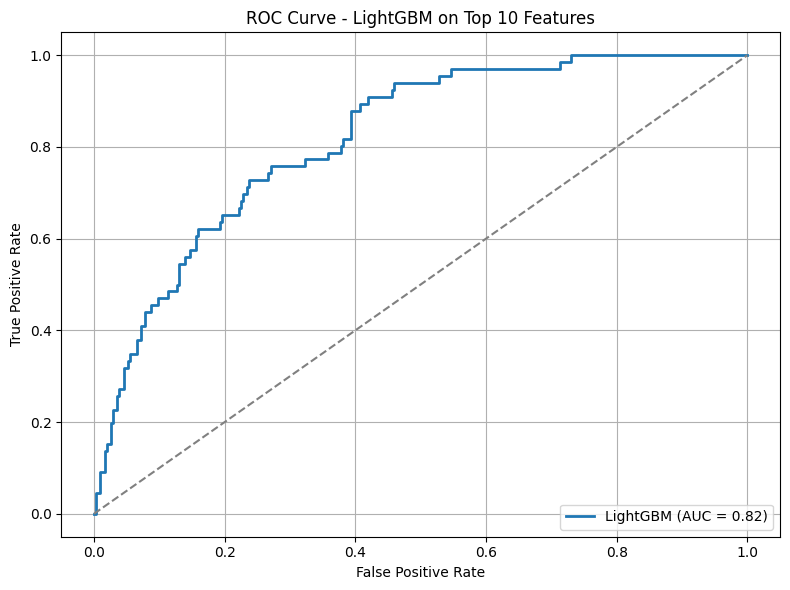

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Convert X_test_top to DataFrame to match training input
X_test_top_df = pd.DataFrame(X_test_top, columns=top_features)

# Get predicted probabilities for the positive class
lgb_probs = lgb_model.predict_proba(X_test_top_df)[:, 1]

# Compute ROC curve and ROC AUC
fpr, tpr, thresholds = roc_curve(y_test, lgb_probs)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'LightGBM (AUC = {roc_auc:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LightGBM on Top 10 Features')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [19]:
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier

# Define parameter space
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10, None],
    'num_leaves': [15, 31, 50, 70],
    'min_child_samples': [10, 20, 30],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Initialize model
lgb_base = LGBMClassifier(random_state=42)

# Run randomized search
random_search = RandomizedSearchCV(
    lgb_base,
    param_distributions=param_dist,
    n_iter=30,
    scoring='roc_auc',
    cv=5,
    random_state=42,
    verbose=1,
    n_jobs=-1
)

# Fit on top feature training set
random_search.fit(X_train_top, y_train_resampled)

# Get the best model
best_lgb = random_search.best_estimator_
print("✅ Best parameters found:", random_search.best_params_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
[LightGBM] [Info] Number of positive: 1227, number of negative: 1227
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 2454, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
✅ Best parameters found: {'subsample': 0.6, 'num_leaves': 15, 'n_estimators': 300, 'min_child_samples': 10, 'max_depth': None, 'learning_rate': 0.2, 'colsample_bytree': 1.0}


In [20]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Predict on test set
lgb_preds_tuned = best_lgb.predict(X_test_top_df)
lgb_probs_tuned = best_lgb.predict_proba(X_test_top_df)[:, 1]

# Evaluate
lgb_results_tuned = {
    "Accuracy": accuracy_score(y_test, lgb_preds_tuned),
    "ROC AUC": roc_auc_score(y_test, lgb_probs_tuned),
    "Report": classification_report(y_test, lgb_preds_tuned, output_dict=True)
}

import pandas as pd
print("📊 Tuned LightGBM Results:\n", pd.DataFrame(lgb_results_tuned["Report"]).T)
print(f"🔵 ROC AUC Score: {lgb_results_tuned['ROC AUC']:.4f}")


📊 Tuned LightGBM Results:
               precision    recall  f1-score     support
0              0.890728  0.876221  0.883415  307.000000
1              0.464789  0.500000  0.481752   66.000000
accuracy       0.809651  0.809651  0.809651    0.809651
macro avg      0.677759  0.688111  0.682584  373.000000
weighted avg   0.815361  0.809651  0.812344  373.000000
🔵 ROC AUC Score: 0.8023


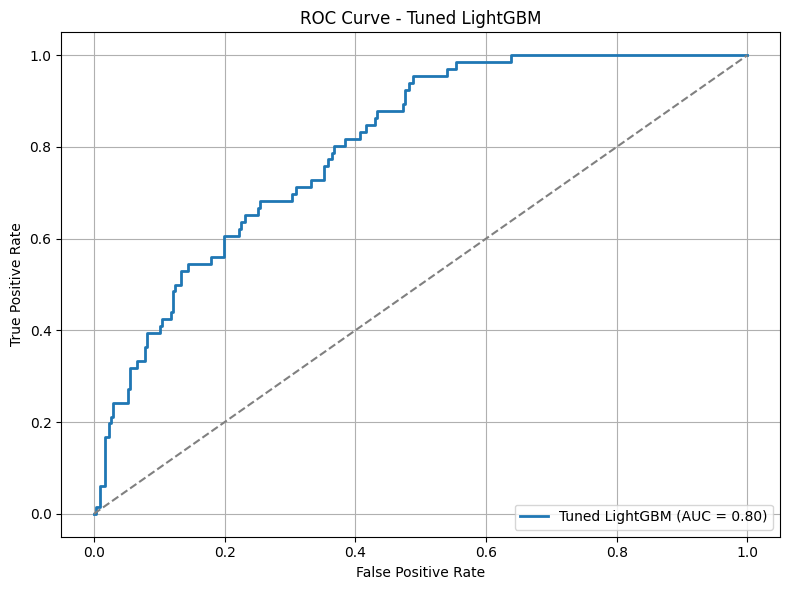

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, lgb_probs_tuned)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Tuned LightGBM (AUC = {roc_auc:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Tuned LightGBM')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [22]:
# Trained tuned model is saved separately
best_lgb = random_search.best_estimator_


In [23]:
# To compare old model with the new one, no need to run everytime

# Predict with the tuned model
lgb_preds_tuned = best_lgb.predict(X_test_top_df)


In [24]:
# Select top 15 features from feature importance DataFrame
top_n = 15
top_features = importance_df['Feature'].iloc[:top_n].tolist()
print("✅ Selected Top 15 Features:\n", top_features)


✅ Selected Top 15 Features:
 ['volume', 'impliedVolatility', 'openInterest', 'moneyness', 'strike', 'ask', 'lastPrice', 'bid', 'percentChange', 'change', 'days_to_expiry', 'spot_price']


In [25]:
# Rebuild X_train_top and X_test_top using top 15 features
X_train_top = X_train_resampled[:, [X_train.columns.get_loc(f) for f in top_features]]
X_test_top = X_test_scaled[:, [X_train.columns.get_loc(f) for f in top_features]]

# Recreate test DataFrame with column names for LightGBM
import pandas as pd
X_test_top_df = pd.DataFrame(X_test_top, columns=top_features)


In [26]:
# Clone and retrain the tuned model using top 15 features
best_lgb = best_lgb.__class__(**best_lgb.get_params())
best_lgb.fit(X_train_top, y_train_resampled)

print("✅ Tuned LightGBM retrained on Top 15 Features.")


[LightGBM] [Info] Number of positive: 1227, number of negative: 1227
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2857
[LightGBM] [Info] Number of data points in the train set: 2454, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
✅ Tuned LightGBM retrained on Top 15 Features.


In [27]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Predict on test set
lgb_preds_15 = best_lgb.predict(X_test_top_df)
lgb_probs_15 = best_lgb.predict_proba(X_test_top_df)[:, 1]

# Evaluate metrics
lgb_results_15 = {
    "Accuracy": accuracy_score(y_test, lgb_preds_15),
    "ROC AUC": roc_auc_score(y_test, lgb_probs_15),
    "Report": classification_report(y_test, lgb_preds_15, output_dict=True)
}

# Display results
print("📊 Tuned LightGBM (Top 15 Features):\n", pd.DataFrame(lgb_results_15['Report']).T)
print(f"🔵 ROC AUC Score: {lgb_results_15['ROC AUC']:.4f}")


📊 Tuned LightGBM (Top 15 Features):
               precision    recall  f1-score     support
0              0.890365  0.872964  0.881579  307.000000
1              0.458333  0.500000  0.478261   66.000000
accuracy       0.806971  0.806971  0.806971    0.806971
macro avg      0.674349  0.686482  0.679920  373.000000
weighted avg   0.813920  0.806971  0.810214  373.000000
🔵 ROC AUC Score: 0.8079


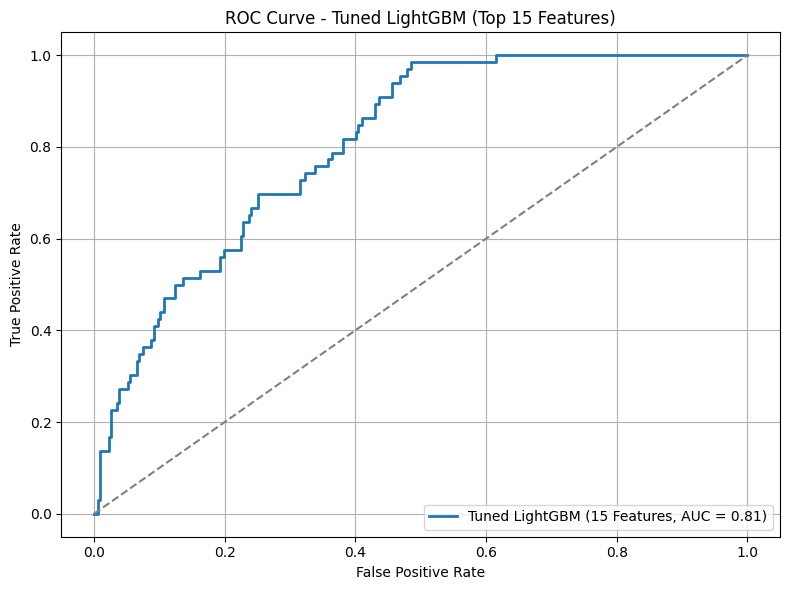

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, lgb_probs_15)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Tuned LightGBM (15 Features, AUC = {roc_auc:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Tuned LightGBM (Top 15 Features)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [29]:
# The model with 15 features is less accurate than the one with 10 but keep it for experimanetation 


✅ SHAP values shape: (373, 12)


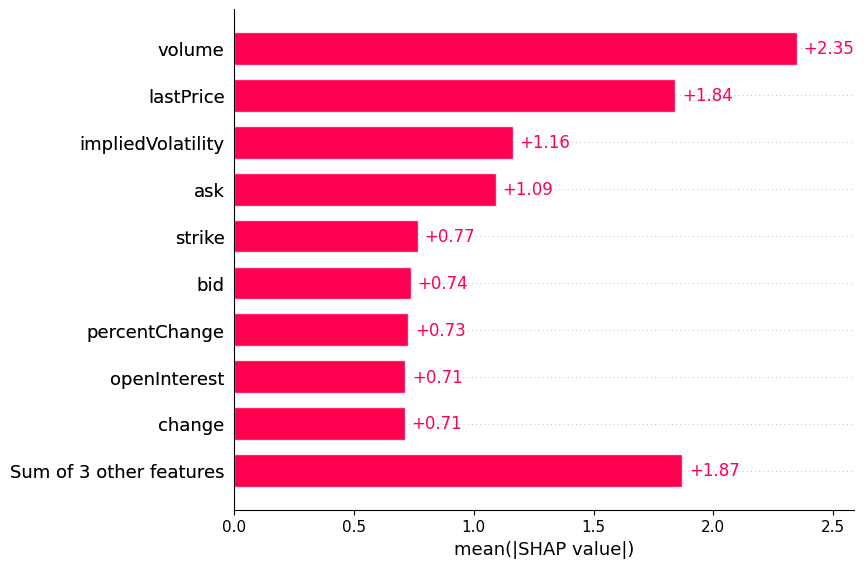

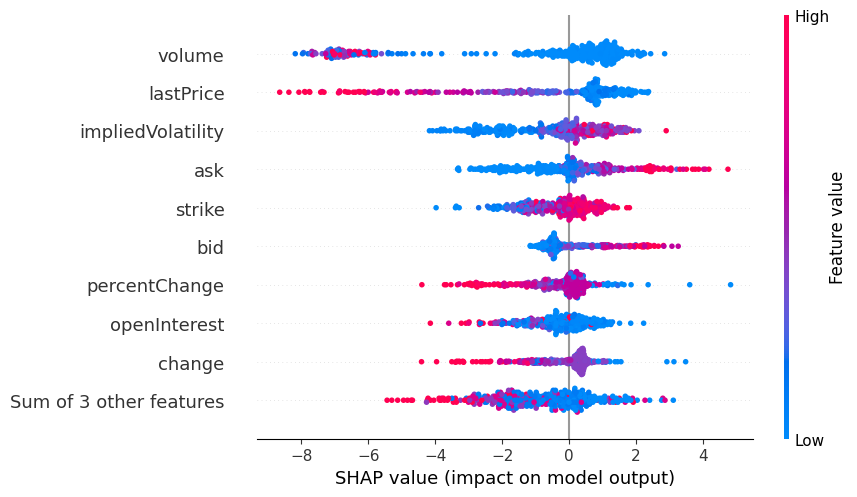

In [37]:
import shap
import pandas as pd

# Rebuild DataFrame for SHAP input using top 15 features
X_test_top_df = pd.DataFrame(X_test_top, columns=top_features)

# Use SHAP's universal Explainer (auto-selects best method)
explainer = shap.Explainer(best_lgb)

# Compute SHAP values for all test samples
shap_values = explainer(X_test_top_df)

# Confirm SHAP shape matches test data
print("✅ SHAP values shape:", shap_values.values.shape)  # Expected: (373, 15)

# 🔹 Summary Bar Plot: Average importance across all samples
shap.plots.bar(shap_values)

# 🔹 Beeswarm Plot: Detailed feature impact per sample
shap.plots.beeswarm(shap_values)
